This notebook is modified from an original document by Marie Rognes

# An introduction to adaptive finite elements using FEniCS

## Non-adaptive finite element method for a classical model problem


Let $\Omega$ be an L-shaped domain  and consider the Poisson problem with a constant source $f = 1.$ and a homogenous dirichleat boundary condition on the left boundary 

In [5]:
from fenics import *
parameters["plotting_backend"] = "matplotlib"
%matplotlib inline
import matplotlib.pyplot as plt

With build the mash using `mshr`

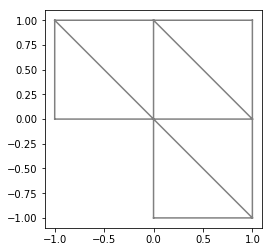

In [6]:
from mshr import *
big_box = Rectangle(Point(-1.0, -1.0), Point(1.0, 1.0))
small_box = Rectangle(Point(-1.0, -1.0), Point(0.0, 0.0))
mesh = generate_mesh(big_box - small_box, 1)
plot(mesh)

We define a standard Poisson solver

In [7]:
k = 1
def poisson(mesh):
    V = FunctionSpace(mesh, "P", k)
    f = Expression("1.",degree =0)
    def left_boundary(x, on_boundary):
        return on_boundary and near(x[0],-1)
    bc = DirichletBC(V, 0., left_boundary)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx
    u_h = Function(V)
    solve(a == L, u_h, bc)
    return (u_h, f)

Ok, let's try solving our Poisson problem on this mesh, and compare the results on that obtained with a uniform fine mesh, that we take as reference.

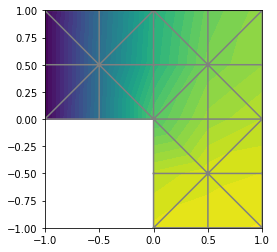

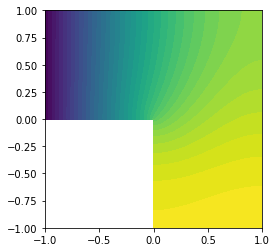

In [8]:
mesh = generate_mesh(big_box - small_box, 1)
mesh = refine(mesh)
(u_h, P_u) = poisson(mesh)
plot(u_h)
plot(u_h.function_space().mesh())

plt.figure()
reference_mesh = generate_mesh(big_box - small_box, 100)
(u_ref, P_ref) = poisson(reference_mesh)
plot(u_ref)

That looks ok in the eyenorm, how about in some other norms? Let's try computing relevant Sobolev norms while refining the mesh a couple of times. 

i =  0
i =  1
i =  2
i =  3
mesh sizes =  [0.3535533905932738, 0.1767766952966369, 0.08838834764831845, 0.04419417382415922]
L^2 errors =  [0.09055754742635815, 0.0346582022412044, 0.012445822714877118, 0.003646440791151021]
H^1_0 errors =  [0.3499540127864317, 0.2181070693345935, 0.13584433153084938, 0.08582984325240609]


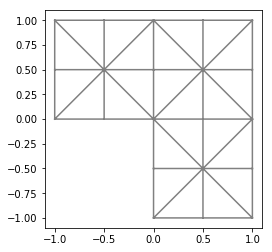

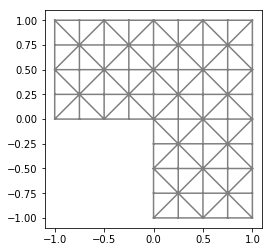

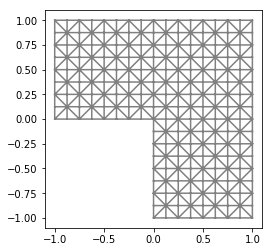

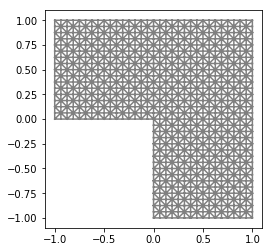

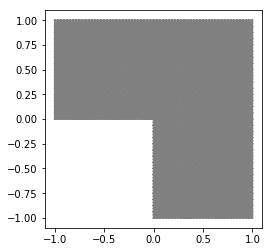

In [9]:
from mshr import *
import pylab
big_box = Rectangle(Point(-1.0, -1.0), Point(1.0, 1.0))
small_box = Rectangle(Point(-1.0, -1.0), Point(0.0, 0.0))
mesh = generate_mesh(big_box - small_box, 1)
mesh = refine(mesh)
plot(mesh)
e_h = []
f_h = []
h = []
for i in range(4):
    print("i = ", i)
    mesh = refine(mesh)
    pylab.figure()
    plot(mesh)
    (u_h, f) = poisson(mesh)
    e_h.append(errornorm(u_ref, u_h, "L2", degree_rise=3))
    f_h.append(errornorm(u_ref, u_h, "H10"))
    h.append(mesh.hmax())
print("mesh sizes = ", h)
print("L^2 errors = ", e_h)
print("H^1_0 errors = ", f_h)

We could plot the errors too, look here: 

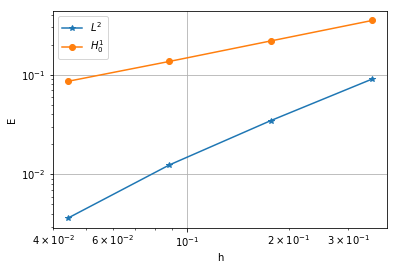

In [10]:
import pylab
pylab.loglog(h, e_h, '*-', label="$L^2$")
pylab.loglog(h, f_h, 'o-', label="$H^1_0$")
pylab.grid(True)
pylab.xlabel('h')
pylab.ylabel('E')
pylab.legend()
pylab.show()

Ok, those errors seem to decrease, but how quickly? Let's compute the convergence rates. 

In [11]:
# Let's compute some convergence rates
import math
def convergence_rates(hs, errors):
    rates = [(math.log(errors[i+1]/errors[i]))/(math.log(hs[i+1]/hs[i]))
            for i in range(len(hs)-1)]
    return rates

print("L2 rates = ", convergence_rates(h, e_h))
print("H^1_0 rates = ", convergence_rates(h, f_h))

L2 rates =  [1.3856380638602381, 1.4775352213266577, 1.7711007272228636]
H^1_0 rates =  [0.6821288192731295, 0.6830821651923024, 0.6624030977337793]


## Adaptive finite elements for a classical model problem

Now, let's continue by trying the adaptive approach for the same problem. Let's start with our original mesh: 

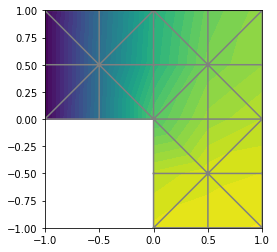

In [12]:
mesh = generate_mesh(big_box - small_box, 1)
mesh = refine(mesh)
(u_h, f) = poisson(mesh)
plot(u_h)
plot(mesh)

Define the interior residual and the jump residual as follows:
\begin{align}
\quad r &= f + \mathrm{div} \, A \, \mathrm{grad} \, u_h \\
\quad j &= \mathrm{jump}(A \, \mathrm{grad} u_h, n)
\end{align}

Now, we would like to compute our favorite error indicator, for instance this residual based one:

\begin{equation}
  E_T^2 = h_T^2 || r ||_{L^2(T)}^2 + h_T || j ||^2_{L^2(\partial T \backslash \partial \Omega)}
\end{equation}

In [13]:
# Get the cell sizes:
h = CellSize(mesh)

# Define the element residual:
r = f + div(grad(u_h))

# Define the jump residual
n = FacetNormal(mesh)
j = jump(grad(u_h), n)

Combining these with a set of piecewise constant basis functions that each are 1 on one cell and zero on the rest, we can define the error indicator as one variational form as follows. (This can be viewed as a neat trick.)
The following new FEniCS syntax is introduced

 - $DG_0$ is the space of function elementwise constant (Discontinous Galerking of order 0)
 - `dS` gives the integral over the boundary of each elemement (hence in the interior of the domain too)
 - `avg` is an operator of UFL defined on the element boundary giving the average between the values of the function calculated form the two elements sharing the same boundary: $\textrm{awg}(w)=\frac{w^++w^-}{2}$. There is a similar operator `jump`, giving the difference.
 
The trick below is that the test function is element-wise constant.
The variational form is a linear form giving once assembled the average on each element (or side) of what multiplying the test function. This allows to calculare the error indicator

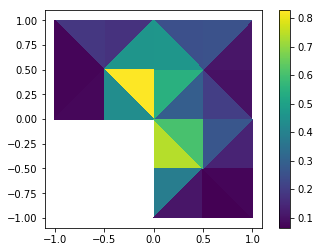

In [15]:
# Create a DG0 function space (piecewise constants, no continuity)
DG0 = FunctionSpace(mesh, "DG", 0)

# Create a test function on this space
w = TestFunction(DG0)

# Define the error indicator form
E_T = h**2*r**2*w*dx + 2*avg(w)*avg(h)*j*j*dS

# Define a function to hold the result of the evaluation
indicators = Function(DG0)

# Assemble the error indicator form into the coefficient vector
assemble(E_T, tensor=indicators.vector())

# Look at them! 
fig = plot(indicators)
plt.colorbar(fig)

Let's combine this into an 'estimate' function: 

In [16]:
def estimate(u_h, f):    
    # Get the cell sizes:
    mesh = u_h.function_space().mesh()
    h = CellSize(mesh)

    # Define the element and jump residual:
    r = f + div(grad(u_h))
    n = FacetNormal(mesh)
    j = jump(grad(u_h), n)

    # Define the error indicator form
    DG0 = FunctionSpace(mesh, "DG", 0)
    w = TestFunction(DG0)
    E_T = h**2*r*r*w*dx + 2*avg(w)*avg(h)*j*j*dS

    # Evaluate the form
    indicators = Function(DG0)
    assemble(E_T, tensor=indicators.vector())
    return indicators

So, now we can do this and still get exactly the same result:

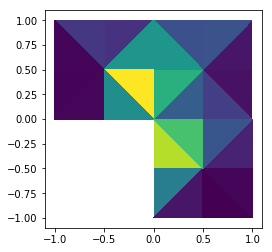

In [17]:
mesh = generate_mesh(big_box - small_box, 1)
mesh = refine(mesh)
(u_h, f) = poisson(mesh)
indicators = estimate(u_h, f)
plot(indicators)

The next step is to use these error estimators for a marking strategy. Dorfler is a good choice: 

In [18]:
import numpy

def mark(alpha, indicators):
    # Sort eta_T in decreasing order and keep track of the cell numbers
    etas = indicators.vector().array()
    indices = etas.argsort()[::-1]
    sorted = etas[indices]
    
    # Compute sum and fraction of indicators
    total = sum(sorted)
    fraction = alpha*total
    
    # Define cell function to hold markers
    mesh = indicators.function_space().mesh()
    markers = CellFunction("bool", mesh, False)
    
    # Iterate over the cells
    v = 0.0
    for i in indices:
        # Stop if we have marked enough
        if v >= fraction:
            break
        # Otherwise
        markers.array()[i] = True
        v += sorted[i]
    return markers

In [19]:
markers = CellFunction("bool", mesh, False)
markers.array()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

In [20]:
# Let's look at these: 
markers = mark(0.3, indicators)
print(markers.array())

[ True  True False False False False  True  True False False False False
 False False False  True False False  True  True False False False  True]


Ok, last thing is to actually refine the mesh, that is easy:

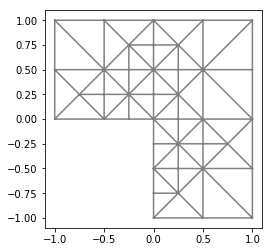

In [21]:
mesh = refine(mesh, markers)
plot(mesh)

### The complete adaptive algorithm

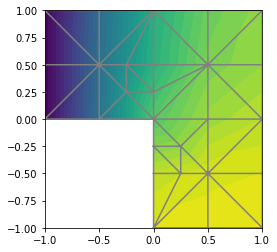

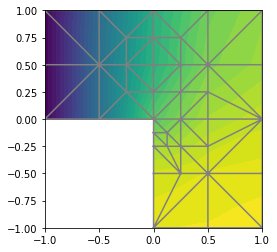

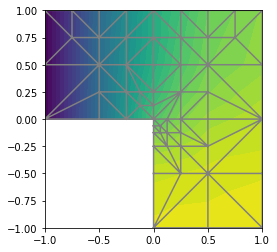

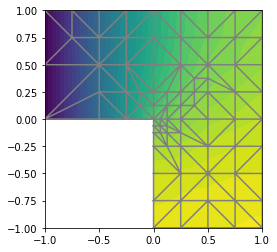

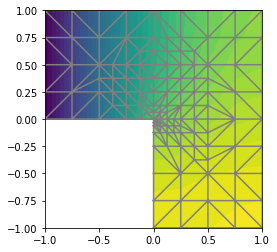

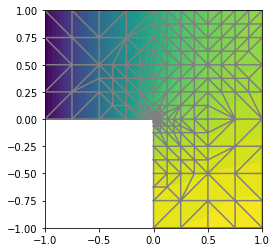

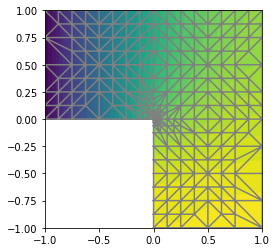

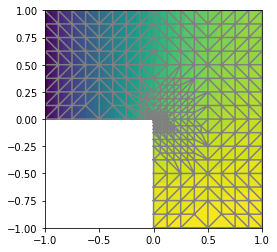

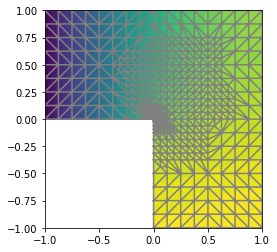

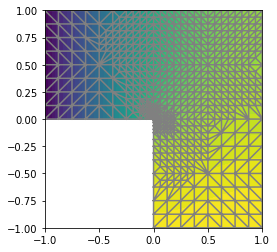

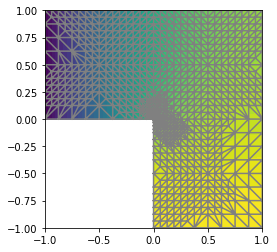

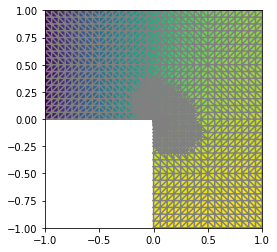

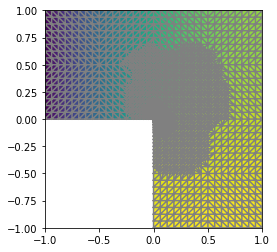

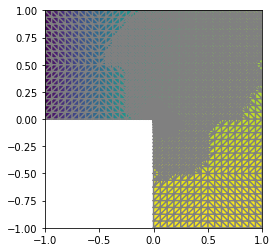

In [22]:
import time 

parameters["refinement_algorithm"] = "regular_cut"
#parameters["refinement_algorithm"] = "recursive_bisection"

mesh = generate_mesh(big_box - small_box, 1)
mesh = refine(mesh)

tolerance = 1.e-3
max_iterations = 15
alpha = 0.1

errors = []
etas = []
Ns = []
i = 1
while (True):
    
    # Solve
    (u_h, f) = poisson(mesh)
    E_h = errornorm(u_ref, u_h, "L2")
    errors.append(E_h)
    
    # Estimate
    indicators = estimate(u_h, f)
    
    # Check stopping criterion
    eta = sum(indicators.vector().array())
    etas.append(eta)
    Ns.append(mesh.num_cells())
    if eta < tolerance or i >= max_iterations:
        break
    
    # Mark
    markers = mark(alpha, indicators)
    
    # Refine
    mesh = refine(mesh, markers)
    plt.figure()
    plot(mesh)
    plot(u_h)
    #
    i += 1


Ns =  [24, 35, 56, 86, 127, 218, 301, 416, 594, 909, 1200, 1646, 2349, 3546, 4730]
etas =  [6.914940395113903, 5.6935272598705744, 3.7969714023882437, 2.9608181320625206, 2.0308053981966938, 1.3346582495241543, 1.0368510381228815, 0.73657451651546491, 0.51189234972971687, 0.3595390455684061, 0.2813478697075425, 0.19913654740900141, 0.1351503040800037, 0.09684525712294699, 0.073543000737542955]


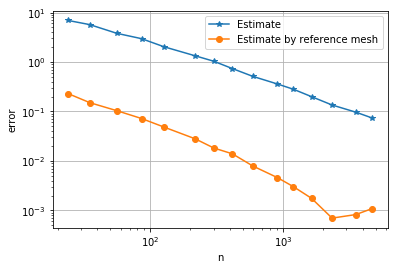

In [25]:
print("Ns = ", Ns)
print("etas = ", etas)
pylab.loglog(Ns, etas, '*-', label="Estimate")
pylab.loglog(Ns, errors, 'o-', label="Estimate by reference mesh")
pylab.legend()
pylab.grid(True)
plt.xlabel("n")
plt.ylabel("error")
pylab.show()

# Howework
1. Compare the effeiciency of uniform and adaptative remeshing, by plotting the errors in two cases as a function of the number of DOF
2. Write an analag adaptative solver for linear elasticity, on the same domain